# Conv4 3D Residual

### Here we visualize traning and test performance of the network on different signal classes.

In [1]:
from keras.models import  load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re, gc
import h5py
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import keras.backend as K
from cnn_utils import *

# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

tf.logging.set_verbosity(tf.logging.ERROR)

## Model performance during training for 150 epochs in total

In [3]:
print('''

Training details:

Epoch 0-50\t Drop_middle=Drop_end=0.7, Drop_resid_conv=0.3
Epoch 50-75\t -//-, Drop_resid_conv=0.4, beta_1=0.95(Adam), MaxNorm=4.0 (weights)
Epoch 75-100\t -//-, reduce_LR_on_plateau
Epoch 100-125\t -//-, signal C30 instead of C100
Epoch 125-150\t -//-, signal C60 instead of C100

''')



Training details:

Epoch 0-50	 Drop_middle=Drop_end=0.7, Drop_resid_conv=0.3
Epoch 50-75	 -//-, Drop_resid_conv=0.4, beta_1=0.95(Adam), MaxNorm=4.0 (weights)
Epoch 75-100	 -//-, reduce_LR_on_plateau
Epoch 100-125	 -//-, signal C30 instead of C100
Epoch 125-150	 -//-, signal C60 instead of C100




In [4]:
loss, valoss, rocs = load_outputs(epochs=['10','50','75','100','125','150'])

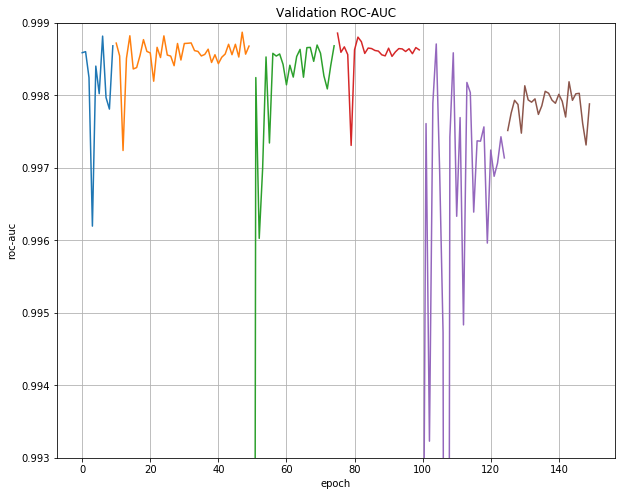

In [5]:
plt.figure(figsize=(10,8))
plt.grid()
plt.xlabel('epoch')
plt.ylabel('roc-auc')
plt.title('Validation ROC-AUC')

plt.plot(range(10),rocs['10'])
plt.plot(range(10,50),rocs['50'])
plt.plot(range(50,75),rocs['75'])
plt.plot(range(75,100),rocs['100'])
plt.plot(range(100,125),rocs['125'])
plt.plot(range(125,150),rocs['150'])
plt.ylim((0.993,0.999))
plt.show()

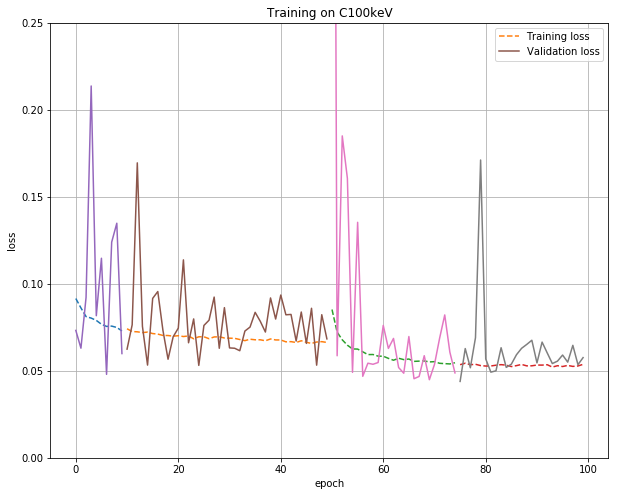

In [6]:
plt.figure(figsize=(10,8))
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training on C100keV')

plt.plot(range(10),loss['10'],'--')
plt.plot(range(10,50),loss['50'],'--', label='Training loss')
plt.plot(range(50,75),loss['75'],'--')
plt.plot(range(75,100),loss['100'],'--')

plt.plot(range(10),valoss['10'])
plt.plot(range(10,50),valoss['50'], label='Validation loss')
plt.plot(range(50,75),valoss['75'])
plt.plot(range(75,100),valoss['100'])

plt.legend()
plt.ylim((0,0.25))
plt.show()

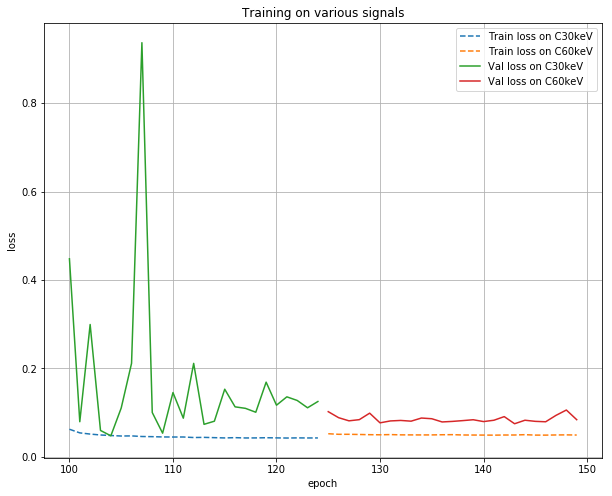

In [7]:
plt.figure(figsize=(10,8))
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training on various signals')

plt.plot(range(100,125),loss['125'],'--', label='Train loss on C30keV')
plt.plot(range(125,150),loss['150'],'--', label='Train loss on C60keV')

plt.plot(range(100,125),valoss['125'], label='Val loss on C30keV')
plt.plot(range(125,150),valoss['150'], label='Val loss on C60keV')

plt.legend()
#plt.yscale('log')
plt.show()

### Some conclusions on the training:
* Playing around with dropout and with optimization parameters (learning rate, momentum) didn't really work on reducing the validation loss oscilations as expected. Needs further study. What might help:
    * Training for more epochs
    * Using more complex learning rate schedulers
    * Using different activation functions (SELU?)
* Training on different signal samples produced huge validation loss oscillations, but seems to stabilise at the end

## Model performance after 150 epochs of training

In [8]:
model = load_model('networks/conv4_3d_res_v1_e150.h5') 

In [9]:
X_test, y_test, preds, pos, neg, prec_curve, rec_curve, thr_curve = {}, {}, {}, {}, {}, {}, {}, {}

C100keV
X_test shape:	(41754, 32, 32, 8, 1)
y_test shape:	(41754,)
41754/41754 [==============================] - 59s    
roc_auc:	 0.998 

C60keV
X_test shape:	(37999, 32, 32, 8, 1)
y_test shape:	(37999,)
37999/37999 [==============================] - 53s    
roc_auc:	 0.99762 

C30keV
X_test shape:	(36822, 32, 32, 8, 1)
y_test shape:	(36822,)
36822/36822 [==============================] - 51s    
roc_auc:	 0.998 



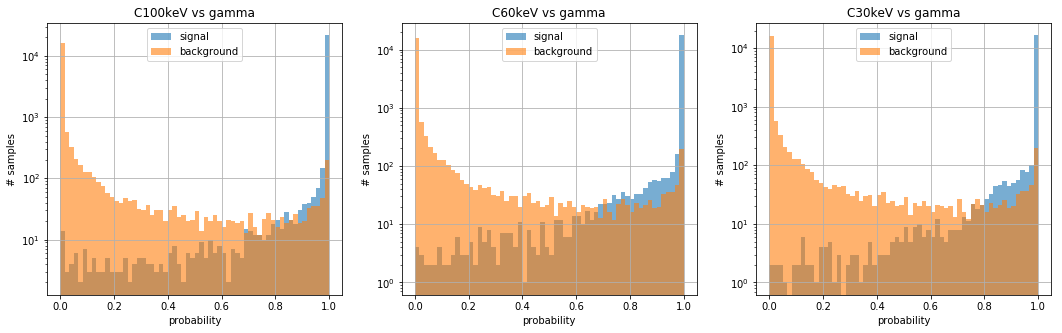

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i,k in enumerate(['C100keV','C60keV','C30keV']):
    print(k)
    X_test[k], y_test[k], _ = load_data(sig_n=k,training=False, images=True, shuf_ind={})
    preds[k] = model.predict(X_test[k],batch_size=128, verbose=1)
    print('roc_auc:\t',round(roc_auc_score(y_test[k], preds[k]), 5),'\n')
    # 1st column = output, 2nd column = index
    pos[k], neg[k] = pos_neg(y_test[k], preds[k])
    axes[i].hist(pos[k][:,0], bins=60, label='signal', alpha=0.6, range=(0,1))
    axes[i].hist(neg[k][:,0], bins=60, label='background', alpha=0.6, range=(0,1))
    axes[i].grid()
    axes[i].set_title(k+' vs gamma')
    axes[i].set_yscale('log')
    axes[i].set_ylabel('# samples')
    axes[i].set_xlabel('probability')
    axes[i].legend()

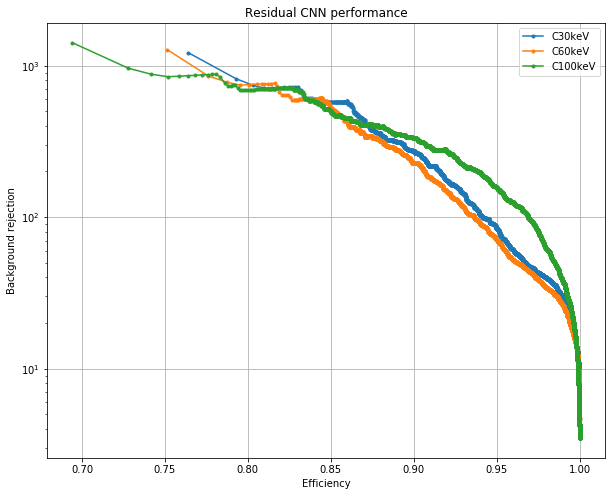

Output probability threshold for the top Background rejection result:	 0.9999999


In [11]:
plt.figure(figsize=(10,8))
plt.grid()
plt.title('Residual CNN performance')
for k in ['C30keV', 'C60keV', 'C100keV']:
    prec_curve[k], rec_curve[k], thr_curve[k] = precision_recall_curve(y_test[k], preds[k])
    plot_mask = rec_curve[k]<0.95
    #plt.plot((rec_curve[k][plot_mask])[:-1],((1-prec_curve[k][plot_mask])[:-1])**-1,'.-', label=k)
    plt.plot(rec_curve[k][:-1],(1-prec_curve[k][:-1])**-1,'.-', label=k)
    #print('Output probability threshold for '+k+' vs gamma plotted between:\n\t',thr_curve[k][-1000],'\t',thr_curve[k][-2])
plt.xlabel('Efficiency')
plt.ylabel('Background rejection')
plt.yscale('log')
plt.legend(loc=1)
plt.show()
print('Output probability threshold for the top Background rejection result:\t',thr_curve['C100keV'][-2])

### Some conclusions:
* CNN parformes is close on different signal classes due to training on all of them for some number of epochs.
    * Training only on one class slightly increases top background rejection for the class and decreases for two other, but does not change situation dramatically.
* CNN achieves 10^3 background rejection on the maximum probability threshold.
* CNN is good at identifying signal and biggest error is coming from misidentifying the background.
    * This should be a signature of some peculiarities of background data.